# Reconstruct full-frame interferogram from bursts

In [1]:
# Consider recent scenes over Mt Rainier

# WARNING: experimental notebook, not thoroughly tested

%load_ext watermark

import asf_search as asf
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import datatree

%watermark --iversions

import concurrent.futures
import gc
import os

numpy     : 1.26.2
IPython   : 8.16.1
datatree  : 0.0.13
xarray    : 2023.11.0
pandas    : 2.1.3
geopandas : 0.14.1
asf_search: 6.7.1



In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Avoid lots of these warnings printing to notebook from asf_search
#/home/jovyan/.local/envs/compass/lib/python3.11/site-packages/asf_search/download/download.py:65: UserWarning: File already exists, skipping download: ./tmp/OPERA_L2_CSLC-S1_T064-135590-IW3_20231011T015408Z_20231012T065442Z_S1A_VV_v1.0.h5
#  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
import warnings
warnings.filterwarnings('ignore')

In [4]:
search_params = dict(
    intersectsWith='POINT(-121.744564 46.796787)',
    dataset='OPERA-S1', # Both CSLC and RTC
    #processingLevel='RTC',
    processingLevel='CSLC',
)

In [5]:
#results = asf_search.geo_search(**search_params) #TypeError: geo_search() got an unexpected keyword argument 'dataset'
results = asf.search(**search_params)
len(results)

20

In [6]:
gf = gpd.GeoDataFrame.from_features(results.geojson(), crs='EPSG:4326')
gf.head()

,geometry,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,...,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber,beamMode,additionalUrls,operaBurstID
0,"POLYGON ((-121.35603 46.78741, -122.49320 46.9...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T013-026571-IW1_20231206T1422...,DESCENDING,S1A_IWDV_0437_0444_051535_013,...,C-SAR,2023-12-06T14:22:21Z,2023-12-06T14:22:24Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.1.0,OPERA_L2_CSLC-S1_T013-026571-IW1_20231206T1422...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T013_026571_IW1
1,"POLYGON ((-121.35603 46.78741, -122.49320 46.9...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T013-026571-IW1_20231206T1422...,DESCENDING,S1A_IWDV_0437_0444_051535_013,...,C-SAR,2023-12-06T14:22:21Z,2023-12-06T14:22:24Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.1.0,OPERA_L2_CSLC-S1_T013-026571-IW1_20231206T1422...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T013_026571_IW1
2,"POLYGON ((-121.86193 46.71037, -121.28656 46.7...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T137-292393-IW3_20231203T0202...,ASCENDING,S1A_IWDV_0147_0154_051484_137,...,C-SAR,2023-12-03T02:02:33Z,2023-12-03T02:02:36Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.1.0,OPERA_L2_CSLC-S1_T137-292393-IW3_20231203T0202...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T137_292393_IW3
3,"POLYGON ((-121.86193 46.71037, -121.28656 46.7...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T137-292393-IW3_20231203T0202...,ASCENDING,S1A_IWDV_0147_0154_051484_137,...,C-SAR,2023-12-03T02:02:33Z,2023-12-03T02:02:36Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.1.0,OPERA_L2_CSLC-S1_T137-292393-IW3_20231203T0202...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T137_292393_IW3
4,"POLYGON ((-121.56282 46.89079, -122.61330 47.0...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T115-245660-IW3_20231201T1414...,DESCENDING,S1A_IWDV_0437_0443_051462_115,...,C-SAR,2023-12-01T14:14:11Z,2023-12-01T14:14:14Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.1.0,OPERA_L2_CSLC-S1_T115-245660-IW3_20231201T1414...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T115_245660_IW3


In [7]:
gf.operaBurstID.value_counts()

operaBurstID
T013_026571_IW1    7
T137_292393_IW3    6
T064_135596_IW1    4
T115_245660_IW3    3
Name: count, dtype: int64

In [8]:
# Pick one
burst = 'T064_135596_IW1'

In [9]:
gf = gf[gf.operaBurstID==burst]
gf[['groupID','startTime']]

,groupID,startTime
5,S1A_IWDV_0148_0155_051411_064,2023-11-28T01:54:22Z
9,S1A_IWDV_0148_0155_051236_064,2023-11-16T01:54:23Z
14,S1A_IWDV_0148_0155_050886_064,2023-10-23T01:54:23Z
18,S1A_IWDV_0148_0155_050711_064,2023-10-11T01:54:23Z


In [10]:
# Get other bursts from the same groupID
search_params = dict(
    #intersectsWith='POINT(-121.744564 46.796787)',
    dataset='OPERA-S1', # Both CSLC and RTC
    processingLevel='CSLC',
    groupID='S1A_IWDV_0148_0155_050711_064' #2023-10-11
)

In [11]:
# Full bust! IW1,2,3
ref = asf.search(**search_params)
len(ref)

27

In [12]:
gfr = gpd.GeoDataFrame.from_features(ref.geojson(), crs='EPSG:4326')
gfr.head()

,geometry,beamModeType,browse,bytes,centerLat,centerLon,faradayRotation,fileID,flightDirection,groupID,...,sensor,startTime,stopTime,url,pgeVersion,fileName,frameNumber,beamMode,additionalUrls,operaBurstID
0,"POLYGON ((-121.13551 47.29787, -121.07032 47.3...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T064-135599-IW2_20231011T0154...,ASCENDING,S1A_IWDV_0148_0155_050711_064,...,C-SAR,2023-10-11T01:54:32Z,2023-10-11T01:54:35Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.0.0,OPERA_L2_CSLC-S1_T064-135599-IW2_20231011T0154...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T064_135599_IW2
1,"POLYGON ((-122.23290 47.09804, -122.16893 47.1...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T064-135599-IW1_20231011T0154...,ASCENDING,S1A_IWDV_0148_0155_050711_064,...,C-SAR,2023-10-11T01:54:31Z,2023-10-11T01:54:34Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.0.0,OPERA_L2_CSLC-S1_T064-135599-IW1_20231011T0154...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T064_135599_IW1
2,"POLYGON ((-119.96095 47.32587, -119.90373 47.3...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T064-135598-IW3_20231011T0154...,ASCENDING,S1A_IWDV_0148_0155_050711_064,...,C-SAR,2023-10-11T01:54:30Z,2023-10-11T01:54:33Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.0.0,OPERA_L2_CSLC-S1_T064-135598-IW3_20231011T0154...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T064_135598_IW3
3,"POLYGON ((-121.08212 47.13377, -121.02143 47.1...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T064-135598-IW2_20231011T0154...,ASCENDING,S1A_IWDV_0148_0155_050711_064,...,C-SAR,2023-10-11T01:54:29Z,2023-10-11T01:54:32Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.0.0,OPERA_L2_CSLC-S1_T064-135598-IW2_20231011T0154...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T064_135598_IW2
4,"POLYGON ((-122.17925 46.93357, -122.11112 46.9...",IW,[https://datapool.asf.alaska.edu/BROWSE/OPERA-...,None,None,None,None,OPERA_L2_CSLC-S1_T064-135598-IW1_20231011T0154...,ASCENDING,S1A_IWDV_0148_0155_050711_064,...,C-SAR,2023-10-11T01:54:28Z,2023-10-11T01:54:31Z,https://datapool.asf.alaska.edu/CSLC/OPERA-S1/...,2.0.0,OPERA_L2_CSLC-S1_T064-135598-IW1_20231011T0154...,None,IW,[https://datapool.asf.alaska.edu/CSLC/OPERA-S1...,T064_135598_IW1


In [13]:
#os.mkdir('./tmp')

In [14]:
# %%time 

# # Warning: OSL shuts down if /tmp files up & only 9 GB available 
# # So save to main drive (500GB)
# asf.download_urls(gfr.url.to_list(), path='./tmp', processes=4)

In [15]:
# Get other bursts from the same groupID
search_params = dict(
    #intersectsWith='POINT(-121.744564 46.796787)',
    dataset='OPERA-S1', # Both CSLC and RTC
    processingLevel='CSLC',
    groupID=['S1A_IWDV_0148_0155_050711_064', 'S1A_IWDV_0148_0155_050886_064'] # #\2023-10-11 2023-10-23
)

In [16]:
# Full bust! IW1,2,3
results = asf.search(**search_params)
len(results)

54

In [17]:
gf = gpd.GeoDataFrame.from_features(results.geojson(), crs='EPSG:4326')
#gf = gf[gf.operaBurstID.str.endswith('IW1')]

In [18]:
#ensure earlier date first
gf = gf.sort_values('startTime')

In [19]:
len(gf)

54

In [20]:
#%%time

# Pre-download all of them in one go
# ~250MB per burst so 250*27 ~7GB per SLC standard frame

#asf.download_urls(gfs1.url.to_list(), path='./tmp', processes=4)

In [21]:
#pairs = gf.groupby('operaBurstID')['fileName'].apply(list) #.apply(lambda x: x['fileName'])
pairs = gf.groupby('operaBurstID')['url'].apply(list)

In [22]:
def burst_ifg(refurl, securl):
    ''' download bursts & calculate interferogram 
    NOTE: save only phase as float32 Geotiff
    NOTE: 90m hardcoded for now
    '''
    scratch = './tmp' # for now just work with local tmp dir
    asf.download_urls([refurl,securl], path=scratch)#, processes=2)
    
    refFile = os.path.basename(refurl)
    secFile = os.path.basename(securl)
    
    _,_,_,burstID,start,_,platformR,pol,version = refFile.split('_')
    _,_,_,burstID,end,_,platformS,_,_ = secFile.split('_')
    
    refPath=f'''NETCDF:"{scratch}/{refFile}"://data/VV'''
    secPath=f'''NETCDF:"{scratch}/{secFile}"://data/VV'''
    
    daR = xr.open_dataarray(refPath, engine='rasterio')
    daS = xr.open_dataarray(secPath, engine='rasterio')
    
    # Possible BUG: rioxarray uses 'spatial_ref' rather than encoding otherwise .rio.crs lost in subsequent operations
    daR = daR.rename(projection='spatial_ref').rio.write_grid_mapping()
    daS = daS.rename(projection='spatial_ref').rio.write_grid_mapping()
    
    ifg = daR * np.conj(daS)
    
    nx=18
    ny=9
    ifg = ifg.coarsen(x=nx, y=ny, boundary='trim').mean()
    
    start = pd.to_datetime(start).tz_localize(None)
    end = pd.to_datetime(end).tz_localize(None)
    
    # Irrelevant if saving geotiff (does not save non-dimensional coordinates...)
    # TODO: explore Zarr
    # ifg = ifg.rename(band='time').assign_coords(
    #                                       time=[start.date()],
    #                                       reference=('time',[start]),
    #                                       secondary=('time',[end]),
    #                                       burst=('time',[burstID])
    #                                      )
    
    # Save phase only
    ifg = xr.apply_ufunc(np.angle, ifg)
    
    outpath = f"{scratch}/{burstID}_{start.strftime('%Y%m%d')}_{end.strftime('%Y%m%d')}.tif"
    
    # TODO: tags
    # Ensure saving nodata value & gdalbuildvrt not liking nans with c64...
    ifg = ifg.rio.write_nodata(-9999, encoded=True)
    ifg.rio.to_raster(outpath)
    
    # BUG? investigate why memory not being freed automatically
    del ifg, daR, daS
    gc.collect()
    
    return outpath

In [23]:
# Work with a single burst
r,s = pairs.iloc[0]

In [24]:
%%time 

# NOTE: ~10s w/o download, ~30s if HDF bursts need downloading
path = burst_ifg(r,s)

CPU times: user 9.71 s, sys: 1.58 s, total: 11.3 s
Wall time: 11.5 s


In [25]:
ifg = xr.open_dataarray(path, engine='rasterio').squeeze()
ifg

<xarray.DataArray 'band_data' (y: 540, x: 1035)>
[558900 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 7.523e+05 7.524e+05 ... 8.453e+05 8.454e+05
  * y            (y) float64 5.143e+06 5.143e+06 ... 5.095e+06 5.095e+06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      VV

CPU times: user 54.3 ms, sys: 471 µs, total: 54.7 ms
Wall time: 51.4 ms


Text(0.5, 1.0, 'band_data')

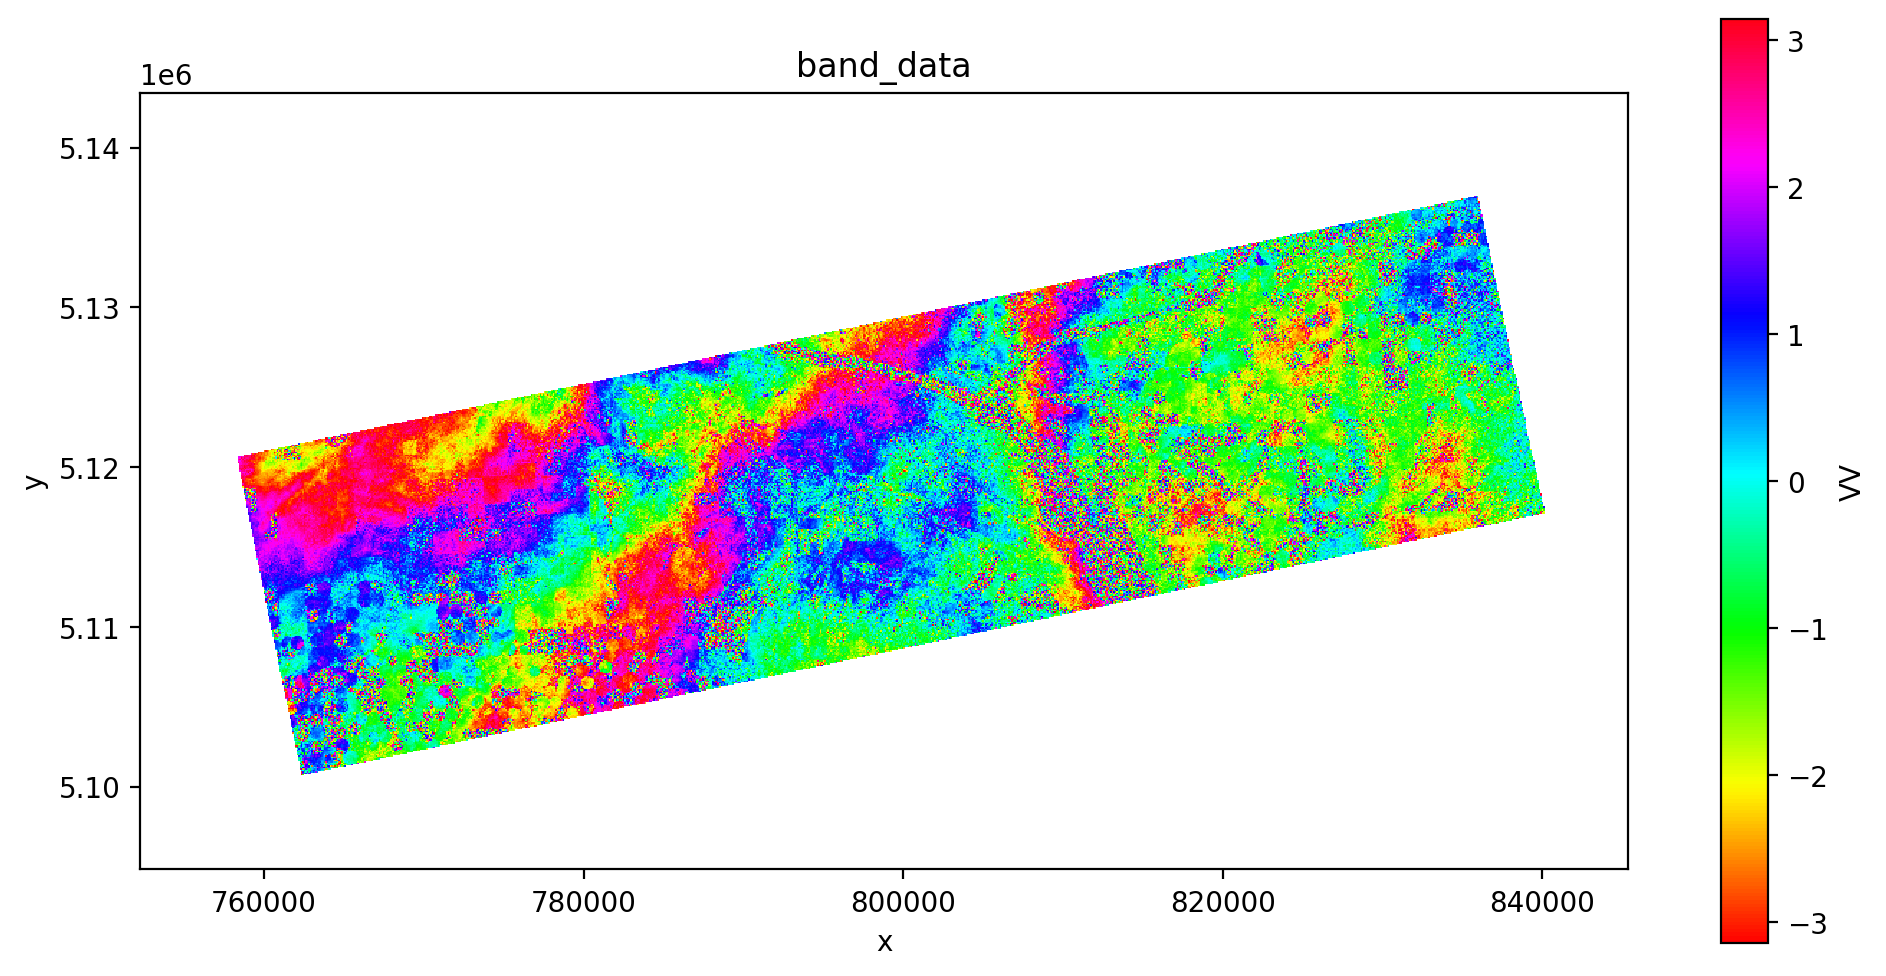

In [26]:
%%time

# NOTE: todo: tighet layout, labels...

fig,ax = plt.subplots(1,1,figsize=(12,6),sharex=True,sharey=True)
ifg.plot.imshow(cmap='hsv', ax=ax) #20m posting
ax.set_aspect('equal')
ax.set_title(ifg.name)

In [27]:
args = [(r,s) for r,s in pairs]
#test = *zip(*args) #separat lists from list of tuples
len(args)

27

In [28]:
%%time

# 30s*27 bursts ~13.5 minutes serial, 6 min 2workers, 3 min 4 workers?

# ASF OSL doesn't have huge resources, so limit parallelism

# Want cluster or machine memory to be ~2x required memory of function to play it safe?
# Some downloading
# CPU times: user 76.6 ms, sys: 129 ms, total: 205 ms
# Wall time: 3min 13s -> even w/ 2 workers!

# all HDFs downloaded:
#CPU times: user 47.6 ms, sys: 106 ms, total: 153 ms
#Wall time: 2min 40s

# TODO: dask cluster
with concurrent.futures.ProcessPoolExecutor(max_workers=2) as executor:
    results = executor.map(burst_ifg, *zip(*args))

CPU times: user 30.7 ms, sys: 47.1 ms, total: 77.8 ms
Wall time: 2min 43s


In [29]:
paths = list(results) 

In [30]:
!ls -lthr ./tmp/*tif | wc

     27     243    2376


In [31]:
!gdalbuildvrt mosaic.vrt ./tmp/*tif 

0...10...20...30...40...50...60...70...80...90...100 - done.


In [32]:
#!gdalinfo mosaic.vrt

In [33]:
ifg = xr.open_dataarray('mosaic.vrt', engine='rasterio').squeeze()
ifg

<xarray.DataArray 'band_data' (y: 2491, x: 3259)>
[8118169 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 5.522e+05 5.523e+05 ... 8.453e+05 8.454e+05
  * y            (y) float64 5.289e+06 5.289e+06 ... 5.065e+06 5.065e+06
    spatial_ref  int64 ...

Text(0.5, 1.0, 'OPERA BURST MOSAIC T064 2023-10-11 2023-10-23')

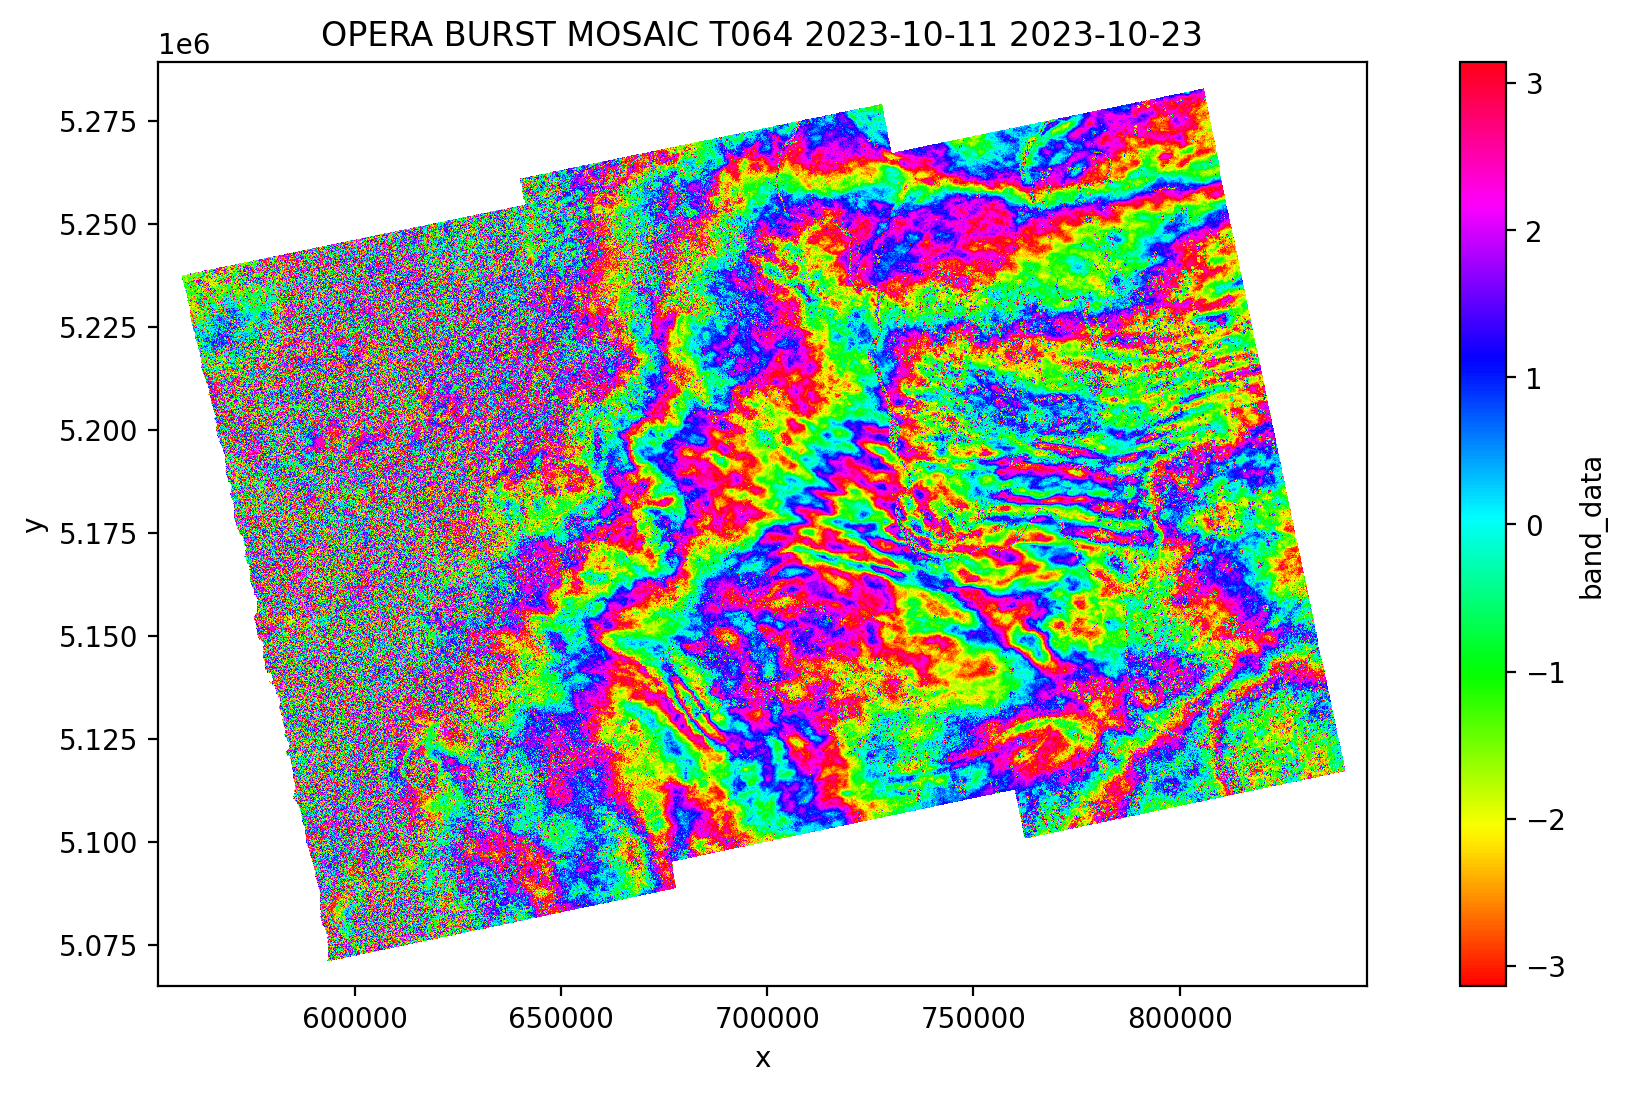

In [34]:
fig,ax = plt.subplots(1,1,figsize=(12,6),sharex=True,sharey=True)
ifg.plot.imshow(cmap='hsv', ax=ax) #20m posting
ax.set_aspect('equal')
ax.set_title('OPERA BURST MOSAIC T064 2023-10-11 2023-10-23')